# Iterative Phase Estimation

## Setup

First, make sure that you have the latest version of Qiskit installed. To upgrade your Qiskit package, run the following command:

```bash
pip install --upgrade qiskit
```

Get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package `qiskit_ionq` using `pip`:

```bash
pip install qiskit_ionq
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [1]:
#import Aer here, before calling qiskit_ionq_provider
from qiskit import Aer

from qiskit_ionq import IonQProvider 

#Call provider and set token value
provider = IonQProvider(token='my token')

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [2]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

### Why do I care about the Iterative Phase Estimation Algorithm (IPEA)? What can you do with it?

Recall your linear algebra knowledge. More specifically, recall the concepts of eigenvalues and eigenvectors. Once you have these two notions solified, consider a unitary operator $U$ and a state $\left|\psi\right>$ such that the following relation is true : 

$$U\left|\psi\right>=e^{2\pi i\phi}\left|\psi\right>$$

In other words, $U$ has eigenvector $\left|\psi\right>$ with corresponding eigenvalue $e^{2\pi i\phi}$. $\phi$ is a real number, and it is our job to find out what its value is. That's it! That's the problem we are trying to solve. And we will solve it using this algorithm known as Iterative Phase Estimation.

### Okay, what is this algorithm and how do we use it to solve this problem?

At this point, I will provide a peripheral explanation of what the algorithm essentially does. The detailed explanation will follow as I actually code the algorithm. Before I give the basic summary though, keep the following point in mind - 

IMPORTANT : We assume that $\phi$, the value we are trying to find, can be expressed as $\frac{\phi_1}{2} + \frac{\phi_2}{4} + \frac{\phi_3}{8} + ... + \frac{\phi_n}{2^n}$. Here each of the $\phi_k$'s are either 0 or 1. Another way of thinking about this key assumption is that $\phi_1\phi_2\phi_3...\phi_n$ is the binary representation of $2^n\phi$ and $n$ is the number of iterations that we do 

Now for the general working : as the name of the algorithm suggests, there will be several iterations. Consider iteration k. The goal of this iteration will be to determine $\phi_{n-k+1}$ in the expression for $\phi$ above. To do this, the algorithm uses a circuit with two qubits : an auxiliary qubit and a main qubit. What will end up happening in every iteration is that $U$ will be acted on the main qubit in such a way that the auxiliary qubit's state, upon measurement, will collapse into $\phi_{n-k+1}$.

### Isn't there the standard Quantum Phase Estimation algorithm that does the same thing with just one iteration?

Before we start, let me answer this good question. Yes, there is the standard Quantum Phase Estimation algorithm (often shortened to QPE) that solves this very problem with one iteration. Why aren't we using that algorithm if it will get the job done faster?

Well, there is a trade-off one has to consider while choosing between the two algorithms. Essentially, the QPEA uses a larger circuit with more qubits, and with more qubits comes more cost in the form of hardware and noise. In contrast, the IPEA just uses two qubits (auxiliary and main). But, of course, where this algorithm loses out is in the number of iterations.

Okay, now let us see how the IPEA works exactly! We are going to try to deduce the phase of the T-gate (our $U = T$). This gate has the following matrix - 

$$T = \begin{bmatrix}
1 & 0\\
0 & e^{i\frac{\pi}{4}}
\end{bmatrix}$$

which clearly tells you that the state $\left|1\right>$ is an eigenstate with eigenvalue $e^{i\frac{\pi}{4}}$. Let's see how our algorithm tells us this. Keep in mind that $\phi = \frac{1}{8}$ in this case because the algorithm gives us $\phi$ in the expression $2\pi i \phi$, and for the T-gate, $2\pi i \phi = i\frac{\pi}{4} \implies \phi = \frac{1}{8}$ 

First, we import every library/module that will be needed.

In [3]:
from qiskit import *
#import qiskit.aqua as aqua
#from qiskit.quantum_info import Pauli
#from qiskit.aqua.operators.primitive_ops import PauliOp
from qiskit.circuit.library import PhaseEstimation
from qiskit import QuantumCircuit

from matplotlib import pyplot as plt
import numpy as np


from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.drivers import Molecule

/Users/abhay/opt/anaconda3/lib/python3.8/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


Now, we write the function `buildControlledT`. As the name suggests, it creates our T-gate and applies it in that special way I alluded to earlier in the basic summary of the IPEA. An even simpler way of describing this function would be that this function performs one iteration of the IPEA. Let's go into more detail and take a look at what happens within one iteration (this description is meant not only to delineate the working of the IPEA, but also to help tracing the code below easier. I highly suggest you read each bullet point, and then find in the code below where this is being implemented before moving on to the next point)- 

- The first thing this function does is create and initialise the circuit. In every iteration, the auxiliary qubit ($q_0$ in our case) will be initialized in the state $\left |+\right> = \frac{1}{\sqrt{2}}(\left|0\right> + \left|1\right>)$, and the other qubit ($q_1$) will be initialised in the state $\left|\psi\right>$ (this is the eigenvector of $U$ from above; in our case, $U=T$ and $\left|\psi\right>=\left|1\right>$). So at this point, our collective state is $\left |+\right> \otimes \left|\psi\right>$ with $\left|\psi\right> = \left|1\right>$ in our case

<br>

- It then applies the CT (controlled-T) gate to the circuit 2<sup>m</sup> times, where the input m is a number that will range from 0 to $n - 1$, where $n$ is the index of the last $\phi_k$ in the expression $\phi = \frac{\phi_1}{2} + \frac{\phi_2}{4} + \frac{\phi_3}{8} + ... + \frac{\phi_n}{2^n}$. In the k<sup>th</sup> iteration, we will apply the T-gate $2^{n-k}$ times. 

    The CT gate functions exactly like a CNOT gate - the only difference is that if the control qubit, in this case always $q_0$, is in state $\left|1\right>$, the $T$ gate will be applied to the target qubit instead of the $X$ gate. The target qubit in our case will be $q_1$. Now, let's see what happens when this gate is applied 2<sup>m</sup> times in terms of the quantum mechanics: 

    We were in the state $\left |+\right> \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + \left|1\right>)\otimes \left|\psi\right>$. Let's see what happens to that state for different values of m - 

    If m = 0, then the T gate is applied $2^0 = 1$ time. So $\frac{1}{\sqrt{2}}(\left|0\right> + \left|1\right>)\otimes \left|\psi\right>$ becomes $\frac{1}{\sqrt{2}}(\left|0\right> \otimes \left|\psi\right>+ \left|1\right> \otimes  e^{2\pi i\phi}\left|\psi\right>) = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i\phi}\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i(\frac{\phi_1}{2} + \frac{\phi_2}{4} + \frac{\phi_3}{8} + ... + \frac{\phi_n}{2^n})}\left|1\right>) \otimes \left|\psi\right>$

    If m = 1, $\frac{1}{\sqrt{2}}(\left|0\right> + \left|1\right>)\otimes \left|\psi\right>$ becomes $\frac{1}{\sqrt{2}}(\left|0\right> \otimes \left|\psi\right>+ \left|1\right> \otimes  e^{2\times2\pi i\phi}\left|\psi\right>) = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\times2\pi i\phi}\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i(\phi_1 + \frac{\phi_2}{2} + \frac{\phi_3}{4} + ... + \frac{\phi_n}{2^{n-1}})}\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i\phi_1}e^{2\pi i(\frac{\phi_2}{2} + \frac{\phi_3}{4} + ... + \frac{\phi_n}{2^{n-1}})}\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i(\frac{\phi_2}{2} + \frac{\phi_3}{4} + ... + \frac{\phi_n}{2^{n-1}})}\left|1\right>) \otimes \left|\psi\right>$
    
    If m = n - 1, $\frac{1}{\sqrt{2}}(\left|0\right> + \left|1\right>)\otimes \left|\psi\right>$ becomes $\frac{1}{\sqrt{2}}(\left|0\right> \otimes \left|\psi\right>+ \left|1\right> \otimes  e^{2^{n-1}\times2\pi i\phi}\left|\psi\right>) = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2^{n-1}\times2\pi i\phi}\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i(2^{n-2}\phi_1 + 2^{n-3}\phi_2 + 2^{n-4}\phi_3 + ... + 2^{-1}\phi_n})\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2^{n-2}\times2\pi i\phi_1}e^{2^{n-3}\times2\pi i\phi_2}...e^{2^{-1}\times2\pi i\phi_n}\left|1\right>) \otimes \left|\psi\right> = \frac{1}{\sqrt{2}}(\left|0\right> + e^{2^{-1}\times2\pi i\phi_n}\left|1\right>) \otimes \left|\psi\right> $

<br>

- The function then performs a phase correction. Why do we need this phase correction? 

Well, first note the following important point, and then we'll get back to that question : if we apply the T-gate to the main qubit $2^{n - 1}$ times, as we will in the first iteration of the IPEA, then m = $n-1$, and as shown above, our circuit's quantum state will be $\frac{1}{\sqrt{2}}(\left|0\right> + e^{2^{-1}\times2\pi i\phi_n}\left|1\right>) \otimes \left|\psi\right>$. In this iteration, our goal is to find $\phi_n$. If $\phi_n = 0$, then this state is just $\left |+\right> \otimes \left|\psi\right>$, and if $\phi_n = 1$, then it's $\left |-\right> \otimes \left|\psi\right>$. This means that if we measure the auxiliary qubit in the x-basis (the basis {$\left |-\right>, \left |+\right>$}), the auxiliary qubit will become $\phi_n$. This is exactly what the "inverse QFT" in the code below is. It is using a Hadamard gate to convert the state $\frac{1}{\sqrt{2}}(\left|0\right> + e^{2^{-1}\times2\pi i\phi_n}\left|1\right>) \otimes \left|\psi\right>$ to either $\left |1\right> \otimes \left|\psi\right>$ if $\phi_n = 1$ (in which case measuring qubit 0 will yield 1), or $\left |0\right> \otimes \left|\psi\right>$ if $\phi_n = 0$ (in which case measuring qubit 0 will yield 0).

Now, back to the original question - why do we need this phase correction? Imagine we apply the T-gate to the main qubit not $2^{n - 1}$ times, but $2^{n - 2}$ times, as we will in the second iteration of the IPEA. Note that in this iteration, our goal will be to find $\phi_{n-1}$. The state will go from $\frac{1}{\sqrt{2}}(\left|0\right> + \left|1\right>)\otimes \left|\psi\right>$ to $\frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i (\frac{\phi_{n-1}}{2} + \frac{\phi_n}{4})}\left|1\right>)\otimes \left|\psi\right>$. But ideally, we would like the state to be $\frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i (\frac{\phi_{n-1}}{2})}\left|1\right>)\otimes \left|\psi\right>$. That's because if that were the state, all it would take is a simple measurement in the x-basis for the auxiliary qubit to collapse to whatever value $\phi_{n-1}$ held (as shown above in the case of the first iteration). So, how do we get the state of the circuit into the ideal state? We can just apply the rotation operator $R_z(\theta)$ with $\theta = \frac{-2\pi\phi_n}{4}$. You can work out the effect of applying this operator to qubit 0. The state that will result will be $e^{i\frac{\pi\phi_n}{4}}\frac{1}{\sqrt{2}}(\left|0\right> + e^{2\pi i \frac{\phi_{n-1}}{2}}\left|1\right>)$. The overall phase can be ignored, and we have the ideal state. This is why we need the phase correction. To remove these unwanted phases and create the state to which only a measurement in the x-basis is necessary to complete the iteration. Generally speaking, for iteration k, $\theta = -2\pi\times(\frac{\phi_{n-k+2}}{4} + \frac{\phi_{n-k+3}}{8} + ... + \frac{\phi_n}{2^n})$

<br>

- Finally, the function does this inverse Quantum Fourier Transform (QFT), which is nothing but a measurement in the Hadamard basis as described in previous bullet point. It then returns the circuit ready for execution on a quantum computer.

In [4]:
def buildControlledT(p, m):

    # initialize the circuit
    qc = QuantumCircuit(2, 1)

    # Hardmard on ancilla, now in |+>
    qc.h(0)

    # initialize to |1>
    qc.x(1)

    # applying T gate to qubit 1
    for i in range(2**m):
        qc.cp(np.pi/4, 0, 1)

    # phase correction
    qc.rz(p, 0)

    # inverse QFT (in other words, just measuring in the x-basis)
    qc.h(0)

    qc.measure([0],[0])

    return qc

The next function, as the name once again suggests, performs the IPEA algorithm. The above function just performed one iteration, and as you can see in the body of this function, there is a `for` loop in which `buildControlledT` is called, which implies that one iteration of this `for` loop represents one iteration of the IPEA. The `for` loop iterates k times (the input of the function). This tells us that the input k of the function signifies the number of iterations in the algorithm. But how many iterations do we want to feed in? Well, as long as $2^n\phi$ can be expressed in binary, we should be good. Remember that each iteration gives you one of the $\phi_k$'s (in particular, the k<sup>th</sup> iteration gives you $\phi_{n-k+1}$). This function does its iterations, and in each iteration, it is basically just creating the circuit with the two qubits, doing what it needs to do (the four bullet points above) to the circuit, running the circuit, recovering the result (the $\phi_k$ for that iteration), and appending it to the bits list. Once we get the bits, we can use the expression $\phi = \frac{\phi_1}{2} + \frac{\phi_2}{4} + \frac{\phi_3}{8} + ... + \frac{\phi_n}{2^n}$ to find $\phi$.

In [5]:
def IPEA(k, backend_string):

    # get backend
    if backend_string == 'qpu':
        backend = provider.get_backend('ionq_qpu')
    elif backend_string == 'qasm':
        backend = Aer.get_backend('qasm_simulator')

    # bits
    bits = []

    # phase correction
    phase = 0.0
    
    # loop over iterations 
    for i in range(k-1, -1, -1):
       
        # construct the circuit
        qc = buildControlledT(phase, i)
         
        # run the circuit
        job = execute(qc, backend)
        
        if backend_string == 'qpu':
            from qiskit.providers.jobstatus import JobStatus
            import time
            # Check if job is done
            while job.status() is not JobStatus.DONE:
                print("Job status is", job.status() )
                time.sleep(60)

            # grab a coffee! This can take up to a few minutes.
            # once we break out of that while loop, we know our job is finished
            print("Job status is", job.status() )
            print(job.get_counts()) # these counts are the “true” counts from the actual QPU Run
        
        # get result
        result = job.result()

        # get current bit
        this_bit = int(max(result.get_counts(), key=result.get_counts().get))
        print(result.get_counts())

        bits.append(this_bit)

        # update phase correction
        phase /= 2
        phase -= (2 * np.pi * this_bit / 4.0)

    return bits

If you have made it this far, then you are doing very well! This algorithm is complicated. Good job! The final function that we will have to define is `eig_from_bits`, which will take in the list of $\phi_k$'s that the above function will return, and return the eigenvalue associated with $\left|\psi\right>$

In [6]:
def eig_from_bits(bits):
    
    eig = 0.

    m = len(bits)

    # loop over all bits
    for k in range(len(bits)):
        eig += bits[k] / (2**(m-k))

    #eig *= 2*np.pi

    return eig

You have now understood the IPEA! Let's actually perform it and see if we can get our $\frac{1}{8}$

In [7]:
# perform IPEA
backend = 'qasm'
bits = IPEA(5, backend)
print(bits)

# re-construct energy
eig = eig_from_bits(bits)

print(eig)

{'0': 1024}
{'0': 1024}
{'1': 1024}
{'0': 1024}
{'0': 1024}
[0, 0, 1, 0, 0]
0.125


It worked! Let's see if we can understand the effect of the choice of input `n` on the result obtained.

{'1': 147, '0': 877}
{'1': 521, '0': 503}
{'1': 147, '0': 877}
{'1': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'1': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'1': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'1': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'0': 1024}
{'1': 1024}
{'0': 1024}
{'0': 1024}


Text(0.5, 1.0, '$\\phi$ vs. n')

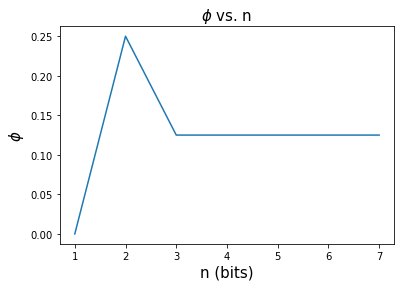

In [8]:
#perform IPEA with different values of n
n_values = []
eig_values = []
for i in range(1, 8):
    n_values.append(i)
    # perform IPEA
    backend = 'qasm'
    bits = IPEA(i, backend)

    # re-construct energy
    eig = eig_from_bits(bits)
    eig_values.append(eig)

n_values, eig_values = np.array(n_values), np.array(eig_values)
plt.plot(n_values, eig_values)
plt.xlabel('n (bits)', fontsize=15)
plt.ylabel(r'$\phi$', fontsize=15)
plt.title(r'$\phi$ vs. n', fontsize=15)

### Now, let's try the same thing on actual IonQ hardware

In [9]:
# perform IPEA
backend = 'qpu'
bits = IPEA(5, backend)
print(bits)

# re-construct energy
eig = eig_from_bits(bits)

print(eig)

/Users/abhay/opt/anaconda3/lib/python3.8/site-packages/qiskit/execute_function.py:343: UserWarning: Option parameter_binds is not used by this backend
  job = backend.run(experiments, **run_kwargs)
/Users/abhay/opt/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/Users/abhay/opt/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#perform IPEA with different values of n
n_values = []
eig_values = []
for i in range(1, 8):
    n_values.append(i)
    # perform IPEA
    backend = 'qpu'
    bits = IPEA(i, backend)

    # re-construct energy
    eig = eig_from_bits(bits)
    eig_values.append(eig)

n_values, eig_values = np.array(n_values), np.array(eig_values)
plt.plot(n_values, eig_values)
plt.xlabel('n (bits)', fontsize=15)
plt.ylabel(r'$\phi$', fontsize=15)
plt.title(r'$\phi$ vs. n', fontsize=15)

### I hope you enjoyed going through this notebook!